# Demonstrate functions dealing with em follow-up

## new events from gracedb

In [126]:
import importlib

# Import the module
import bot.new_events_utils

# Re-import the specific function
GetSuperevents = importlib.reload(bot.new_events_utils).GetSuperevents

In [2]:
# get events from gracedb that we haven't already saved

from bot.new_events_utils import GetSuperevents
params = GetSuperevents(path_events_dictionary='bot/data', 
                        mlp_modelpath='bot/mlp_model.sav',
                        event_source='gracedb',
                        runid='O4c',
                        retrieve_all=True).get_new_events()

19 significant superevents in O4c
https://gracedb.ligo.org/api/superevents/S250221gb/files/none
https://gracedb.ligo.org/api/superevents/S250221eb/files/none
14 events (cut 3 low prob bbh events)


In [3]:
# check the trigger status on fritz and check if we handled the event correctly

eventid = [x[0] for x in params]
dateid = [x[12] for x in params]
a90 = [x[16] for x in params]
far = [x[9] for x in params]
mass = [x[22] for x in params]

from bot.new_events_utils import Fritz
trigger_status = Fritz(eventid, dateid, a90, far, mass).get_trigger_status()

There are currently 125 observation plans generated
Event doesnt pass criteria - correct no plan request for S250331o
Event doesnt pass criteria - correct no plan request for S250328ae
not triggered on S250326y
triggered on S250319bu
Event doesnt pass criteria - correct no plan request for S250304cb
Event doesnt pass criteria - correct no plan request for S250226dl
Event doesnt pass criteria - correct no plan request for S250211be
Event doesnt pass criteria - correct no plan request for S250211aa
Event doesnt pass criteria - correct no plan request for S250208ad
Event doesnt pass criteria - correct no plan request for S250207bg
Event doesnt pass criteria - correct no plan request for S250205ee
Event doesnt pass criteria - correct no plan request for S250205bk
not triggered on S250204ax
Event doesnt pass criteria - correct no plan request for S250202cu
0 errors, 14 correct, 0 inspect


In [4]:
# compile event information and save to the dictionary of events

from bot.new_events_utils import NewEventsToDict
df = NewEventsToDict(params, trigger_status, path_events_dictionary='bot/data', check_before_run=False).save_data()
df

New events not saved.


,GW MJD,90% Area (deg2),50% Area (deg2),Distance (Gpc),FAR (years/FA),Mass (M_sol),gcnids,trigger,plan time,plan probability,plan start,cadence
graceids,,,,,,,,,,,,
S250331o,60765,18,5,0.66,100.0,30,2025-03-31T01:34:48,not triggered,,,,
S250328ae,60762,14,3,0.51,100.0,24,2025-03-28T05:40:27,not triggered,,,,
S250326y,60760,1460,380,5.41,5400.0,190,2025-03-26T01:54:06,not triggered,420,0.19,2025-03-27T09:21:29.745,"[2025-04-03, 2025-04-10, 2025-04-17, 2025-04-2..."
S250319bu,60753,989,236,4.71,67.6,162,2025-03-19T06:25:36,triggered,2220,0.9,2025-03-20T02:53:29.028,"[2025-03-27, 2025-04-03, 2025-04-10, 2025-04-1..."
S250304cb,60738,1569,407,1.77,0.6,43,2025-03-04T06:22:46,not triggered,,,,
S250226dl,60733,1218,382,3.36,3400.0,124,2025-02-26T22:48:39,not triggered,,,,
S250211be,60717,90,19,3.34,1.8,83,2025-02-11T04:35:43,not triggered,,,,
S250211aa,60717,248,56,1.12,1100.0,41,2025-02-11T02:25:47,not triggered,,,,
S250208ad,60714,1128,188,4.87,84.5,167,2025-02-08T03:51:07,not triggered,,,,


In [51]:
# default arguments set at contour=90, mindec=-90

eventid = [x[0] for x in params]
skymap_str = [x[18] for x in params]
zmin = [x[19] for x in params]
zmax = [x[20] for x in params]

from bot.new_events_utils import KowalskiCrossmatch
crossmatch = KowalskiCrossmatch(eventid, skymap_str, dateid, zmin, zmax, path_events_dictionary='bot/data')
matches = crossmatch.get_crossmatches()

0 events are missing crossmatch: []
data for these events were provided, but they were skipped because only new crossmatches were performed: {'S250328ae', 'S250205ee', 'S250326y', 'S250226dl', 'S250208ad', 'S250207bg', 'S250202cu', 'S250331o', 'S250205bk', 'S250319bu', 'S250211aa', 'S250304cb', 'S250211be', 'S250204ax'}
Crossmatching 0 events: []
No catnorth crossmatch


In [18]:
from astropy.table import Table
import astropy_healpix as ah
from io import BytesIO
import base64
import numpy as np
import astropy.units as u

In [22]:
skymapstring = skymap_str[0]
coords = catnorth_unsorted[0]

skymap = Table.read(BytesIO(base64.b64decode(skymapstring)))
max_level = 29 # arbitrarily high resolution
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
index = ipix * (2**(max_level - level))**2
sorter = np.argsort(index)
agn_prob = []
for coord in [coords[0]]:
    ra, dec = coord['ra'] * u.deg, coord['dec'] * u.deg
    print(type(ra), type(dec))
    match_ipix = ah.lonlat_to_healpix(ra, dec, max_nside, order='nested')
    i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
    prob = skymap[i]['PROBDENSITY']
    agn_prob.append(prob)
paired = list(zip(agn_prob, coords))
paired_sorted = sorted(paired, key=lambda x: x[0], reverse=True)

prob_sorted, coords_sorted = zip(*paired_sorted)
coords_sorted = list(coords_sorted)
print(prob_sorted)

<class 'astropy.units.quantity.Quantity'> <class 'astropy.units.quantity.Quantity'>
(0.0,)


In [23]:
coords_sorted

[{'_id': 325620815243378944, 'ra': 32.52685814, 'dec': 32.87098877}]

In [20]:
catnorth_unsorted

[[{'_id': 325620815243378944, 'ra': 32.52685814, 'dec': 32.87098877},
  {'_id': 301504436437144832, 'ra': 30.82083831, 'dec': 31.30433909},
  {'_id': 301571270423407232, 'ra': 30.10734768, 'dec': 31.59576556},
  {'_id': 299762367637252096,
   'ra': 31.62417585,
   'dec': 29.01630432,
   'z_xp_nn': 0.12330000102519989}]]

In [88]:
import matplotlib.pyplot as plt
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
import ligo.skymap.postprocess
import ligo.skymap.io
import matplotlib.pyplot as plt
import ligo.skymap.postprocess

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype([('UNIQ', '<i8'), ('PROBDENSITY', '<f8'), ('DISTMU', '<f8'), ('DISTSIGMA', '<f8'), ('DISTNORM', '<f8')]), dtype([('UNIQ', '<i8'), ('PROBDENSITY', '<f8'), ('DISTMU', '<f8'), ('DISTSIGMA', '<f8'), ('DISTNORM', '<f8')])) -> None

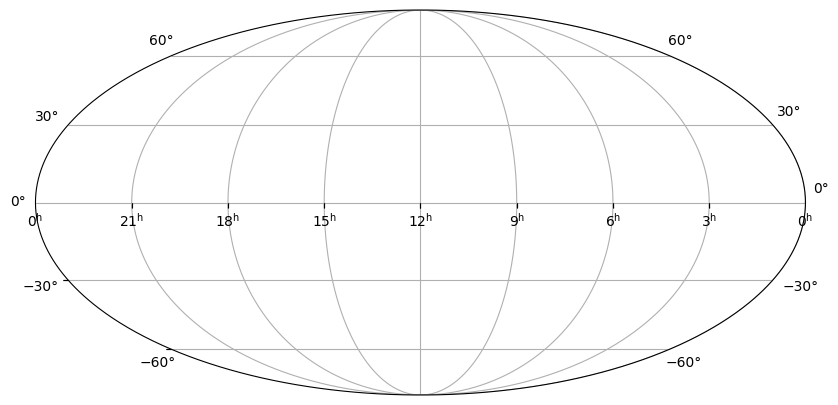

In [99]:
# plot coords on skymap

def plot_skymaps(skymap, RA_unit="hours"):
    """
    Plot skymaps

    Parameters
    ----------
    skymaps : list of skymaps
    RA_unit : unit for the right ascension, either hours or degrees
    """
    fig = plt.figure(figsize=(10, 5))
    if RA_unit == "degrees":
        ax = plt.axes(projection='astro degrees mollweide')
    elif RA_unit == "hours":
        ax = plt.axes(projection='astro hours mollweide')
    else:
        raise ValueError("Does not understand {}".format(RA_unit))
    ax.grid()
    contour = ax.contour_hpx((ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap), 'ICRS'), 
                             levels=[0.5, 0.9], 
                             linewidths=1, 
                             nested=True, 
                             colors='blue')
    plt.title('test')
    plt.show()

plot_skymaps(skymap)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype([('UNIQ', '<i8'), ('PROBDENSITY', '<f8'), ('DISTMU', '<f8'), ('DISTSIGMA', '<f8'), ('DISTNORM', '<f8')]), dtype([('UNIQ', '<i8'), ('PROBDENSITY', '<f8'), ('DISTMU', '<f8'), ('DISTSIGMA', '<f8'), ('DISTNORM', '<f8')])) -> None

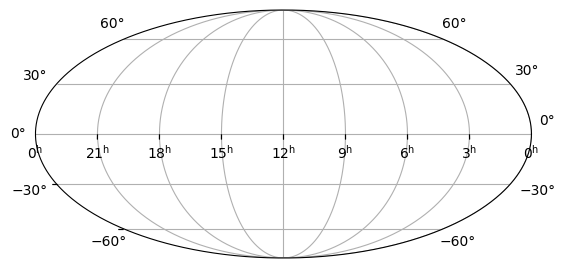

In [103]:
import ligo.skymap.plot
from matplotlib import pyplot as plt
ax = plt.axes(projection='astro hours mollweide')
ax.grid()
ax.contour_hpx((ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap), 'ICRS'), levels=[0.5, 0.9], linewidths=1, nested=True, colors='blue')

In [127]:
from bot.new_events_utils import PushEventsPublic
df, priority, trigger_df, error_triggers = PushEventsPublic(path_events_dictionary='bot/data',testing=True, verbose=True).format_and_push()

2 O4c events with FAR > 10 and mass > 60 and area < 1000 sq deg


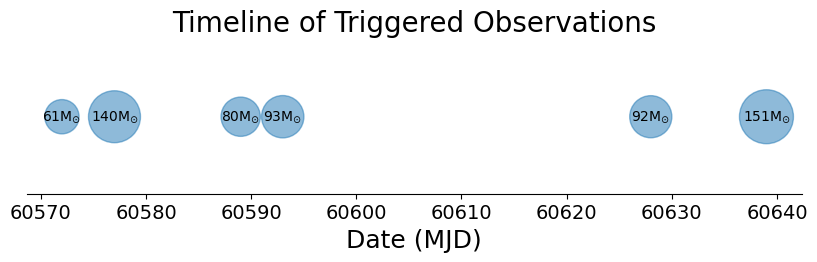

In [128]:
PushEventsPublic.plot_trigger_timeline()

# ZTF forced photometry service

In [43]:
# check photometry status

from bot.photometry_utils import PhotometryStatus
PhotometryStatus('O4b', path_events_dictionary='bot/data').show_status()

76 / 98 events in O4b are not priority


,ID,Date last zfps,Status,Trigger
0,S240630t,,needs ZFPS,
1,S250118dp,2025-02-11 18:14:52.995,update ZFPS,
2,S250119ag,2025-02-11 18:19:05.806,update ZFPS,
3,S250109f,2025-01-24 21:21:42.071,update ZFPS,
4,S250108eo,2025-01-24 21:18:05.241,update ZFPS,
5,S241210cw,2025-01-24 23:32:19.070,update ZFPS,
6,S241129aa,2025-01-24 23:35:29.537,update ZFPS,
7,S241130n,2025-01-24 23:38:29.530,update ZFPS,
8,S241114y,2025-01-24 21:04:56.625,update ZFPS,True
9,S241009em,NA,no AGN,True


85 / 3819 dataframes for 3825 Catnorth sources are empty


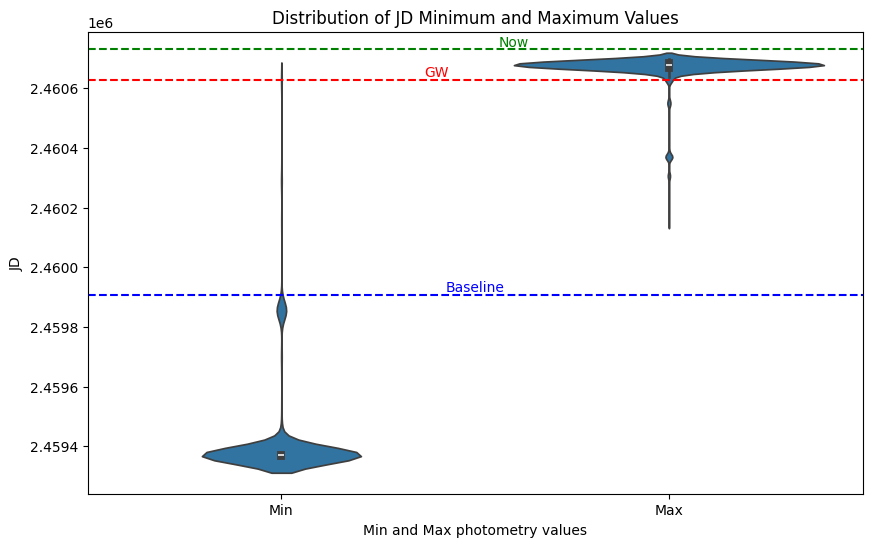

In [49]:
from bot.photometry_utils import PlotPhotometry
PlotPhotometry(graceid='S241114y', path_events_dictionary='bot/data', path_photometry='../../../data/bbh/ZFPS/').plot_photometry_dates()

In [53]:
from bot.photometry_utils import PhotometryCoords
ra, dec, jd = PhotometryCoords(action='update', 
                               graceid='S241114y', 
                               catalog=['catnorth'], 
                               verbose=True,
                               path_events_dictionary='bot/data',
                               path_photometry='../../../data/bbh/ZFPS/').get_photometry_coords()

last photometry request for S241114y was on 2025-01-24 21:04:56.625
Found saved photometry for 3819 / 3825 coords crossmatched
3819 coords are valid for update photometry
After batching dates with window size 60, created 4 batches
Fewer than 1500 AGN - submit in one batch
Fewer than 1500 AGN - submit in one batch
Fewer than 1500 AGN - submit in one batch
More than 1500 AGN - submit in 3 batches
After batching for ZFPS, retrieved 3819 objects in 6 batches


In [134]:
from bot.photometry_utils import GetPhotometry

#GetPhotometry(graceid='S241114y', ra, dec, jd)

In [ ]:
from bot.photometry_utils import SavePhotometry

#SavePhotometry(graceid='S241114y', batch_codes=['11127'], action='update', path_photometry='../../../data/bbh/ZFPS/').save_photometry()

## rolling window heuristic for flares

In [55]:
import importlib
import bot.flares_utils
importlib.reload(bot.flares_utils)

<module 'bot.flares_utils' from '/home/kira/mypy/repos/BBHBot/FlareBot/bot/flares_utils.py'>

In [56]:
from bot.flares_utils import FlarePreprocessing
AGN = FlarePreprocessing(graceid='S241114y', 
                         path_events_dictionary='bot/data', 
                         path_photometry='../../../data/bbh/ZFPS/').process_for_flare()

found 3819 AGN


In [57]:
# default arguments window_size_before=50, window_size_after=25, baseline_years=2

from bot.flares_utils import RollingWindowStats
stats = RollingWindowStats(graceid='S241114y', agn=AGN, path_events_dictionary='bot/data').get_rolling_window_stats()

In [58]:
# k_mad defines the scalar on the mean absolute deviations that a point in the GW window must be brighter than,
# percent defines the percentage of baseline medians that must meet this criteria

from bot.flares_utils import RollingWindowHeuristic
g, r, i, gr, gri = RollingWindowHeuristic(graceid='S241114y', 
                                          agn=AGN, 
                                          rolling_stats=stats, 
                                          path_events_dictionary='bot/data',
                                          percent=0.6, 
                                          k_mad=3, 
                                          save=False).get_flares()

in g,r,i we find 1066,1471,427 candidates
1908 unique flares across all colors
707 AGN have flares in g and r filters
221 AGN have flares in g, r, and i filters
335 / 3819 have no observations in any color in 200 day post GW period
136 / 3819 have no observations in any color before the GW detection


# plot matches from a fully processed graceid

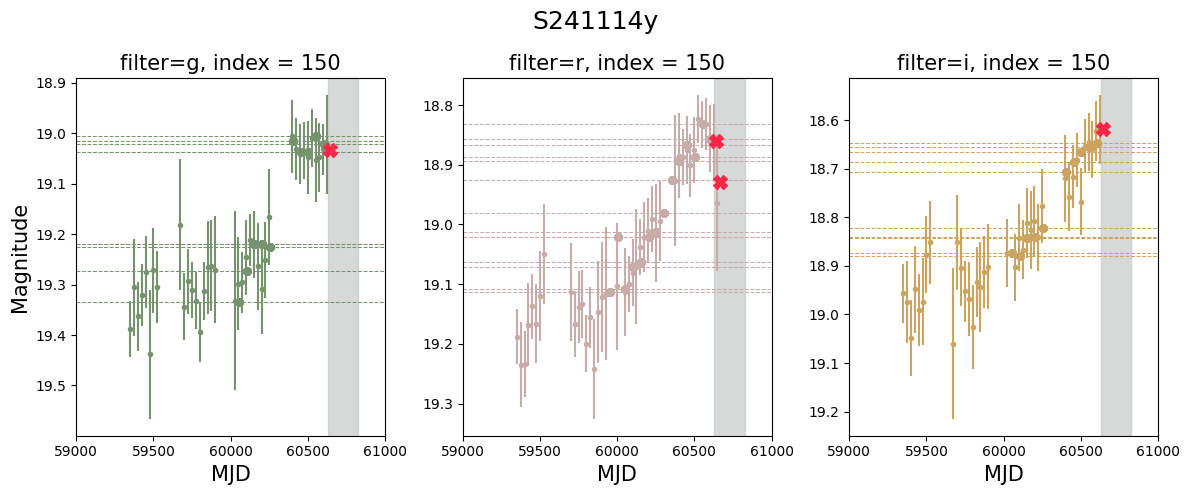

[None]

In [59]:
# plot given the values defined above
from bot.flares_utils import Plotter

# plot from an index:
plot_index = gri[0:1].tolist()
[Plotter(index_to_plot=[i], 
         color_to_plot='all', 
         agn=AGN, 
         rolling_stats=stats, 
         graceid='S241114y', 
         path_events_dictionary='bot/data').show_plots() for i in plot_index]